In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

In [2]:
from cx_spiking.central_complex import CX_SPIKING
from cx_spiking.constants import *
import cx_spiking 

In [3]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=False)


######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz


In [7]:
######################################
### SPIKING CX
######################################
cpu4_method = 1

mem_gain_outbound = 0.05
decay_outbound= 0.025
mem_gain_inbound = 0.05
decay_inbound = 0.033

rotation_factor = 0.1

spiking_cx = CX_SPIKING(eqs, threshold_eqs, reset_eqs,
                        h, v, 
                        mem_gain_outbound, decay_outbound, mem_gain_inbound, decay_inbound,
                        rotation_factor, time_step=20, T_outbound=T_outbound,
                        T_inbound=T_inbound, 
                        headings_method='vonmises', cpu4_method=1,
                        only_tuned_network=True, 
                        follow_stone_rotation=True,
                        cx_log=cx_log)

Run network outbound for 1500 steps
Starting simulation at t=0. s for a duration of 30. s
3.6291 s (12%) simulated in 10s, estimated 1m 13s remaining.
7.3492 s (24%) simulated in 20s, estimated 1m 2s remaining.
10.9651 s (36%) simulated in 30s, estimated 52s remaining.
14.5988 s (48%) simulated in 40s, estimated 42s remaining.
18.2181 s (60%) simulated in 50s, estimated 32s remaining.
21.9066 s (73%) simulated in 1m 0s, estimated 22s remaining.
25.5909 s (85%) simulated in 1m 10s, estimated 12s remaining.
29.2266 s (97%) simulated in 1m 20s, estimated 2s remaining.
30. s (100%) simulated in 1m 22s


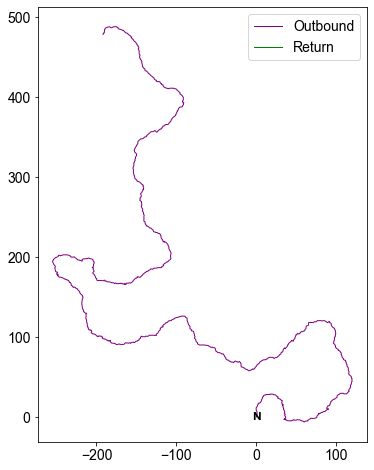

In [8]:
spiking_cx.run_outbound()
spiking_cx.plot_bee_position()

Run network inbound for 1500 steps
Starting simulation at t=30. s for a duration of 30. s
3.6752 s (12%) simulated in 10s, estimated 1m 12s remaining.
7.374 s (24%) simulated in 20s, estimated 1m 1s remaining.
11.0198 s (36%) simulated in 30s, estimated 52s remaining.
14.6276 s (48%) simulated in 40s, estimated 42s remaining.
18.3461 s (61%) simulated in 50s, estimated 32s remaining.
22.0773 s (73%) simulated in 1m 0s, estimated 22s remaining.
25.7632 s (85%) simulated in 1m 10s, estimated 12s remaining.
29.376 s (97%) simulated in 1m 20s, estimated 2s remaining.
30. s (100%) simulated in 1m 21s


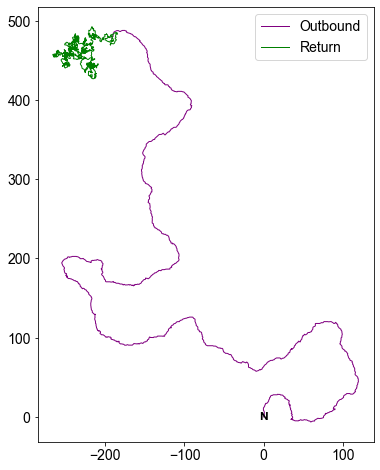

In [9]:
spiking_cx.run_inbound(follow_stone_inbound=False)
spiking_cx.plot_bee_position()

In [36]:
def plot_one_paths(spiking_cx, figsize=(8,8), save=False):
    plt.figure(figsize=(10,10))
    plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
    plt.plot(spiking_cx.bee_coords[:spiking_cx.T_outbound,0], spiking_cx.bee_coords[:spiking_cx.T_outbound,1], color='purple', lw=2, label='Outbound')
    plt.plot(spiking_cx.bee_coords[spiking_cx.T_outbound:,0], spiking_cx.bee_coords[spiking_cx.T_outbound:,1], color='green', lw=2, label='Inbound')
    plt.legend(fontsize=20)
    plt.xlabel('Distance [steps]', fontsize=22)
    plt.ylabel('Distance [steps]', fontsize=22)
    plt.axis('scaled')
#     plt.tight_layout()
    if save:
        plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/spiking_cx_following.pdf'), bbox_inches = "tight")
    plt.show()



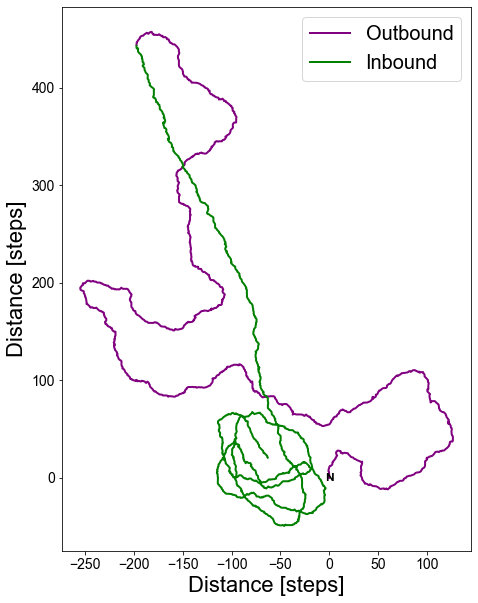

In [37]:
plot_one_paths(spiking_cx, figsize=(8,8), save=True)

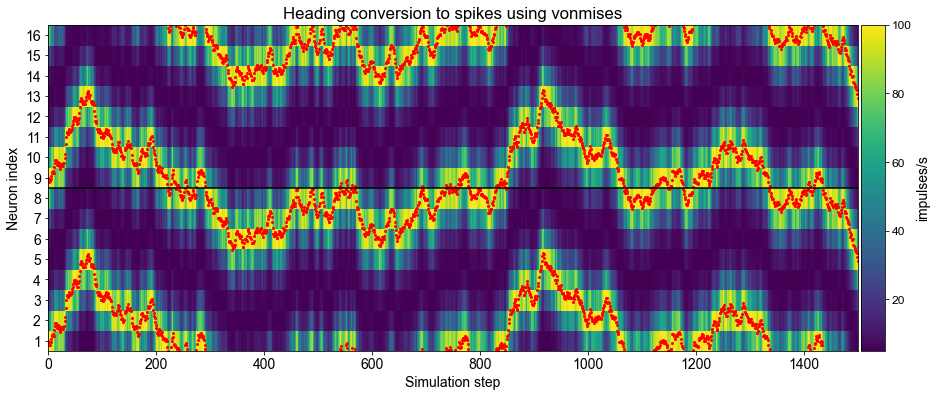

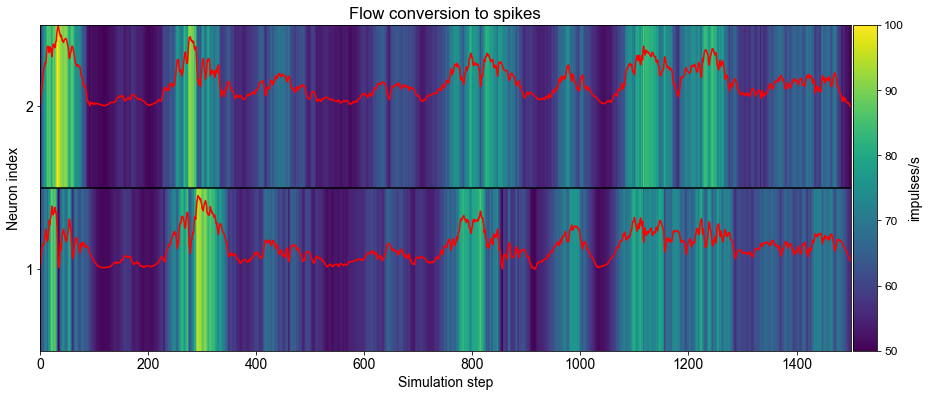

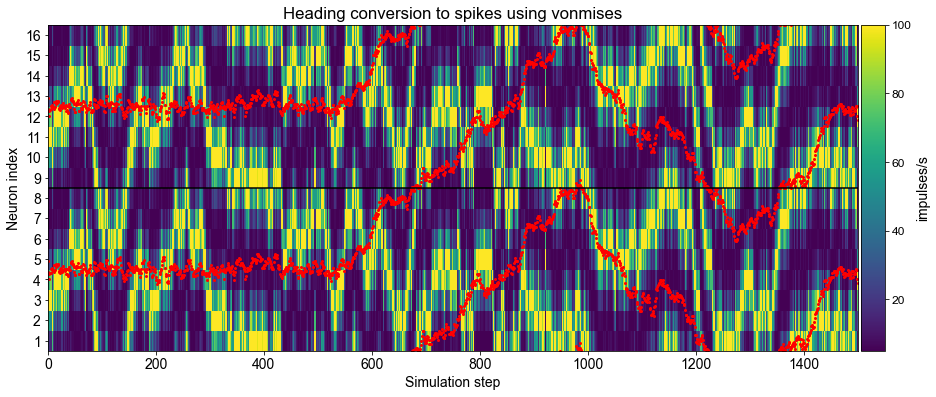

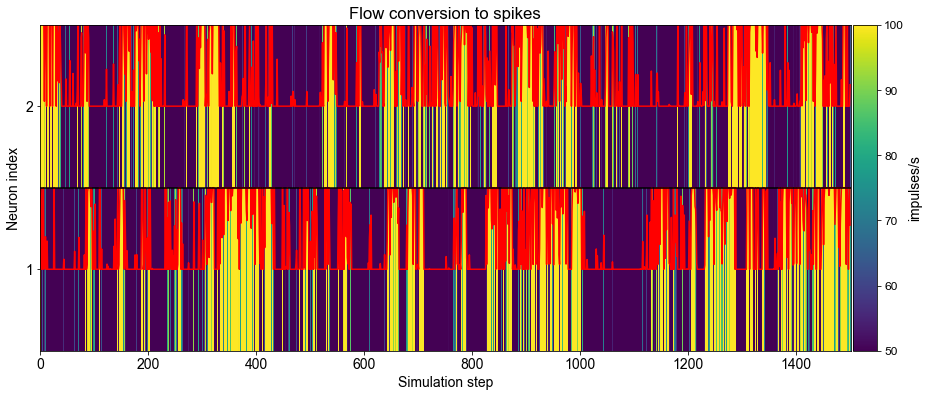

In [23]:
cx_spiking.plotting.plot_inputs_outbound(spiking_cx, h, v)
cx_spiking.plotting.plot_inputs_inbound(spiking_cx, h, v)

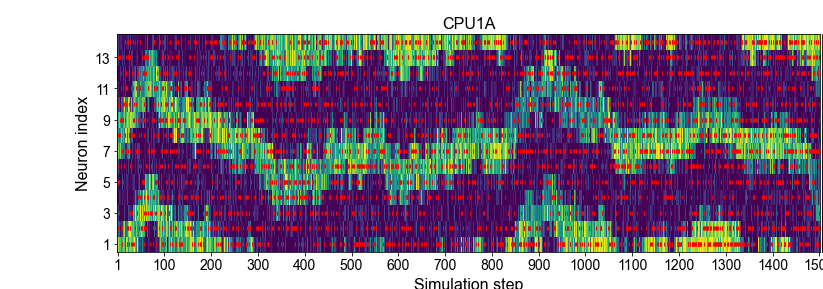

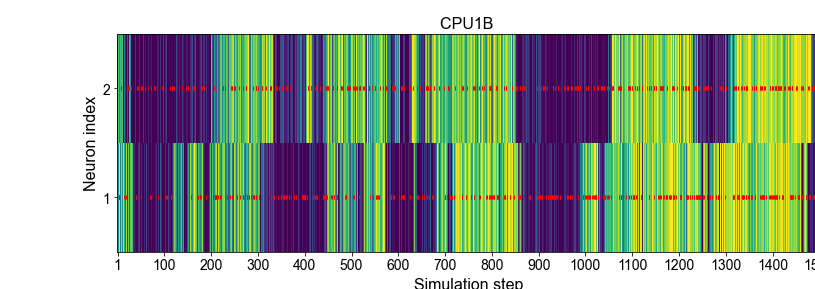

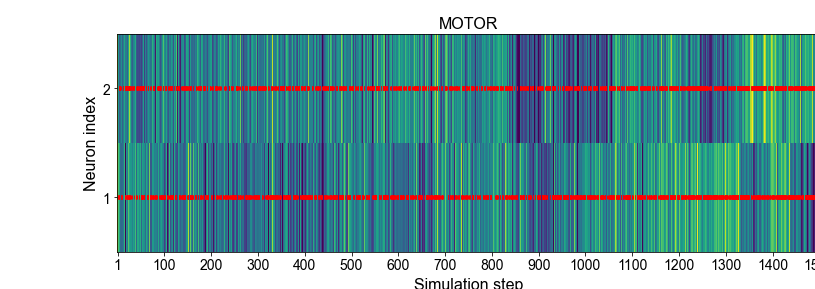

In [24]:
cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[1:-1,:], 1, spiking_cx.SPM_CPU1A, spiking_cx.time_step,
                        title='CPU1A',  figsize=(13,4), xlim=[0,spiking_cx.T_outbound+1], fontsize=16,
                                savefig_=os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu1a_outbound.pdf'))

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[[0,-1],:], 1, spiking_cx.SPM_CPU1B, spiking_cx.time_step, 
                        title='CPU1B ',  figsize=(13,4), xlim=[0,spiking_cx.T_outbound+1], fontsize=16,
                                savefig_=os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu1b_outbound.pdf'))

motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
cx_spiking.plotting.plot_motors_cx_log_spikes(motors/motors.max(), 1, spiking_cx.SPM_MOTOR, spiking_cx.time_step, 
                        min_rate=motors.min(), 
                        title='MOTOR',  figsize=(13,4), xlim=[0,spiking_cx.T_outbound+1], fontsize=16,
                                savefig_=os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/motor_outbound.pdf'))


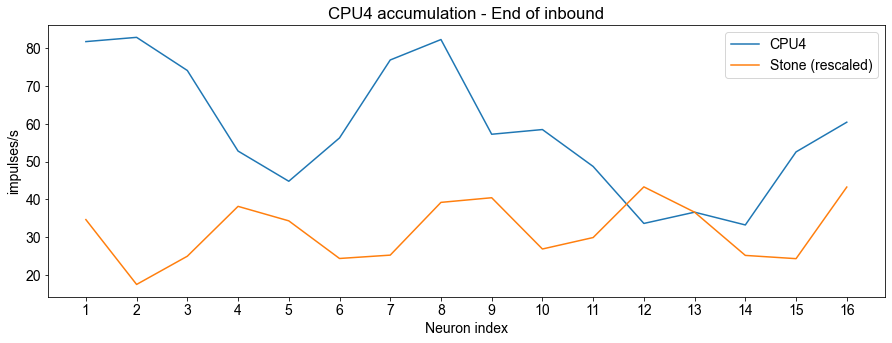

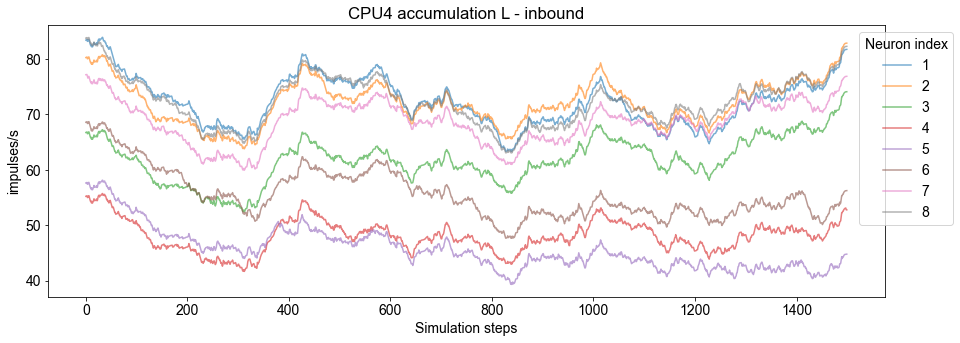

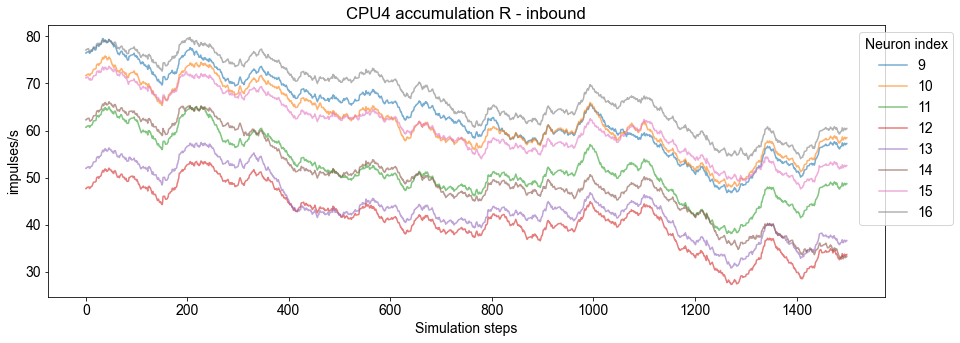

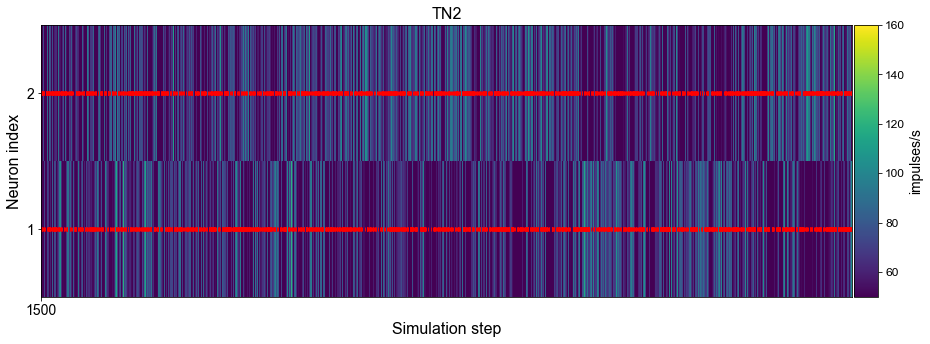

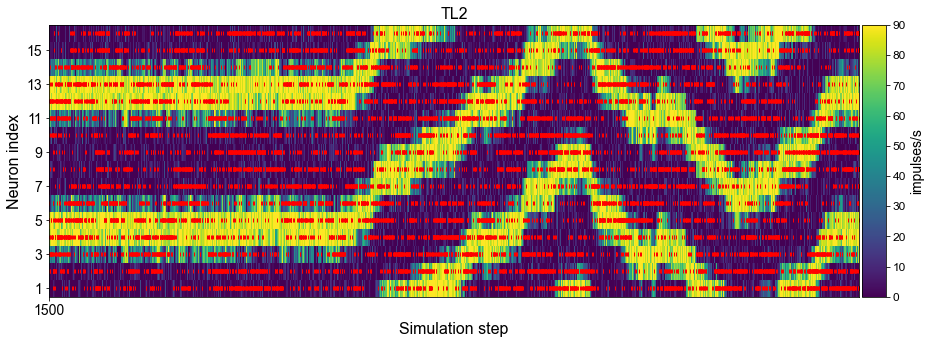

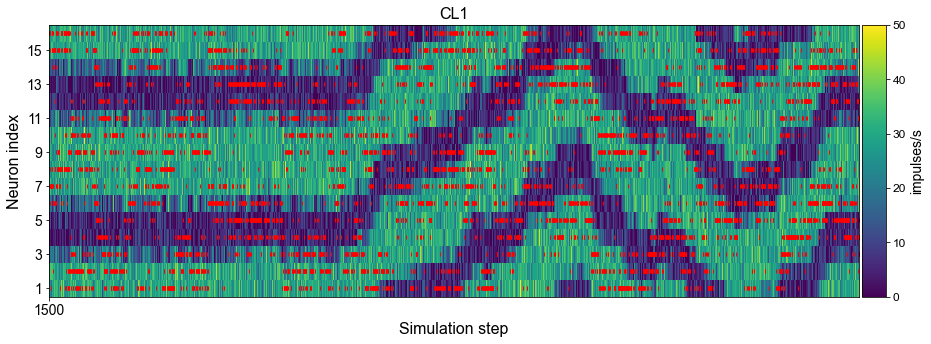

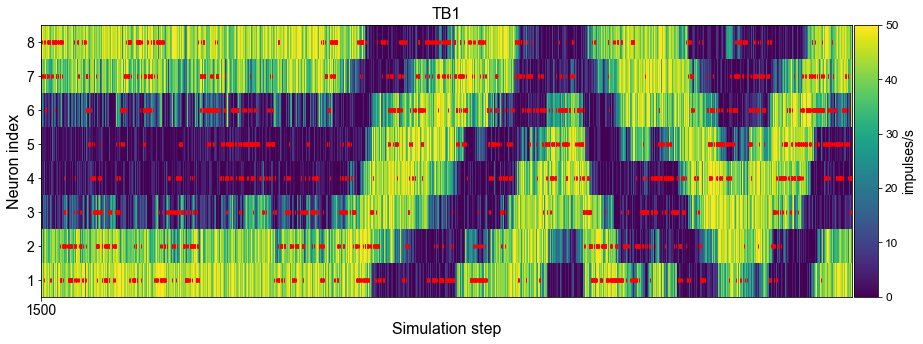

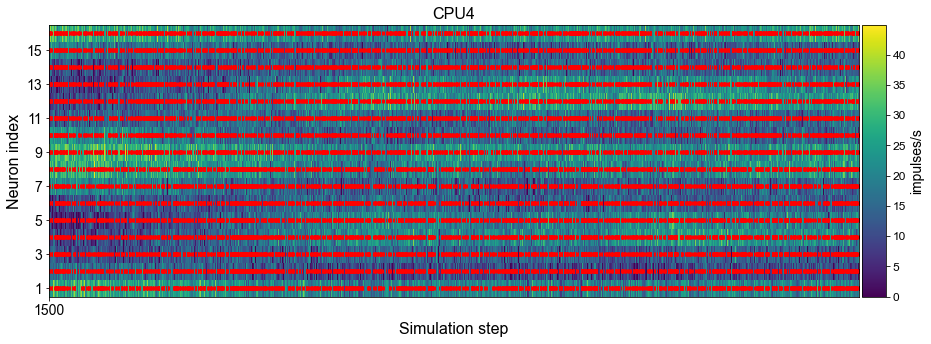

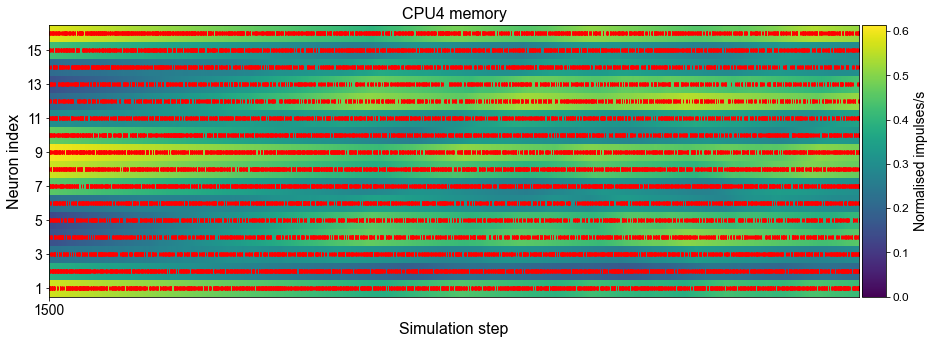

In [25]:
cx_spiking.plotting.plot_memory_inbound(spiking_cx, cx_log)
cx_spiking.plotting.plot_populations_inbound(spiking_cx, cx_log)

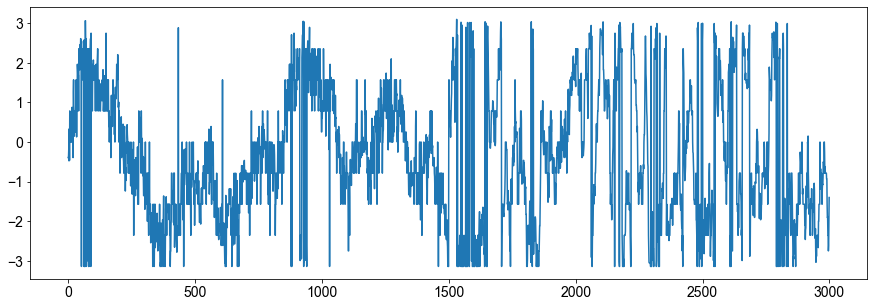

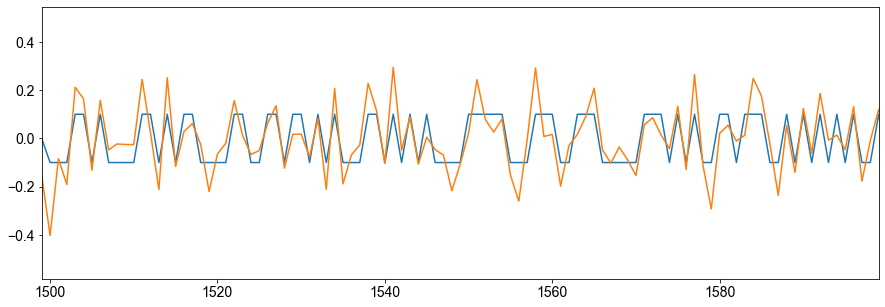

In [21]:
plt.figure(figsize=(15,5))
plt.plot(spiking_cx.heading_angles)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(spiking_cx.rotations*10)
# plt.xlim([1499,1699])
# plt.show()

# plt.figure(figsize=(15,5))
plt.plot(cx_log.motor)
plt.xlim([1499,1599])
plt.show()

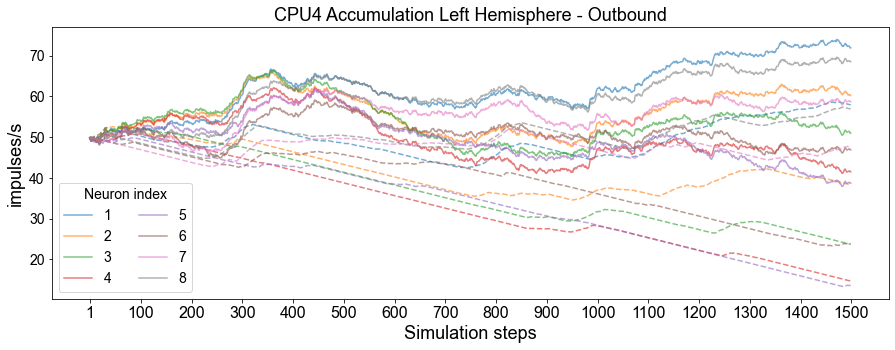

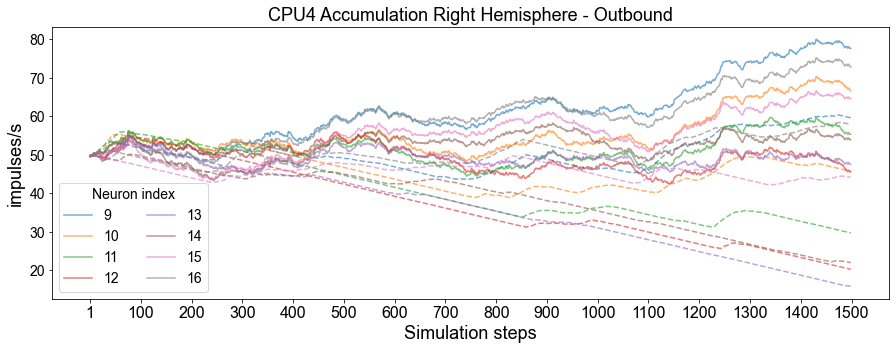

In [150]:
def local_plot_memory_outbound(spiking_cx, cx_log, figsize=(8,4)):
    plt.figure(figsize=figsize)
    plt.plot(spiking_cx.CPU4_memory_history[spiking_cx.T_outbound-1], label='CPU4')
    plt.plot(cx_log.memory[:,spiking_cx.T_outbound-1] * spiking_cx.CPU4_memory_history[spiking_cx.T_outbound-1].max(), label='Stone (rescaled)')
    plt.legend()
    plt.xlabel('Neuron index')
    plt.xticks(np.arange(0, N_CPU4), np.arange(1, N_CPU4+1))
    plt.ylabel('impulses/s')
    plt.title('CPU4 accumulation - End of outbound')
    plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu4_memory_example.pdf'),
                 bbox_inches='tight')
    plt.show()

# local_plot_memory_outbound(spiking_cx, cx_log)

def plot_memory_outbound_accumulation(spiking_cx, cx_log, figsize=(15,5), savefig_=False):
    cmap = matplotlib.cm.get_cmap('tab10')
    plt.figure(figsize=figsize)
    ranges = range(spiking_cx.CPU4_memory_history.shape[1]//2)
    for r in ranges:
        plt.plot(spiking_cx.CPU4_memory_history[:spiking_cx.T_outbound,r], alpha=0.6, label=r+1, color=cmap.colors[r])#, label=names[idx])
        plt.plot(cx_log.memory[r,:spiking_cx.T_outbound]*100, ls='--', alpha=0.6, color=cmap.colors[r])
#     plt.legend(bbox_to_anchor=(1.09, 1), title='Neuron index')
    plt.legend(title='Neuron index', ncol=2)

    #plt.xlim([1400,1500])
    plt.title('CPU4 Accumulation Left Hemisphere - Outbound', fontsize=18)
    plt.xticks(np.arange(0, T_outbound+1, 100) + 0.5, [1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=18-2)

    plt.ylabel('impulses/s', fontsize=18)
    plt.xlabel('Simulation steps', fontsize=18)
    
    plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu4_acc_left.pdf'),
                 bbox_inches='tight')
    plt.show()

    plt.figure(figsize=figsize)
    ranges = range(spiking_cx.CPU4_memory_history.shape[1]//2)
    for r in ranges:
        plt.plot(spiking_cx.CPU4_memory_history[:spiking_cx.T_outbound,r+8], alpha=0.6, label=r+1+8)#, label=names[idx])
        plt.plot(cx_log.memory[r+8,:spiking_cx.T_outbound]*100, ls='--', alpha=0.6, color=cmap.colors[r])

#     plt.legend(bbox_to_anchor=(1.09, 1), title='Neuron index')
    plt.legend(title='Neuron index', ncol=2)
    #plt.xlim([1400,1500])
    plt.title('CPU4 Accumulation Right Hemisphere - Outbound', fontsize=18)
    plt.xticks(np.arange(0, T_outbound+1, 100) + 0.5, [1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=18-2)


    plt.ylabel('impulses/s', fontsize=18)
    plt.xlabel('Simulation steps', fontsize=18)
    plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu4_acc_right.pdf'),
                 bbox_inches='tight')


    plt.show()

plot_memory_outbound_accumulation(spiking_cx, cx_log, figsize=(15,5), savefig_=True)